# Example Model

## Setup Environment

In [1]:
from pathlib import Path, PurePath

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
DATASET_URL="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

## Training Data

### Prepare Dataset

In [34]:
data_file = Path(
    tf.keras.utils.get_file(
        "cats_and_dogs.zip",
        origin=DATASET_URL,
        extract=True,
    )
)

data_dir = data_file.parent / "cats_and_dogs_filtered"
train_dir = data_dir / "train"
validation_dir = data_dir / "validation"

Path.mkdir(data_dir, exist_ok=True)
Path.mkdir(train_dir, exist_ok=True)
Path.mkdir(validation_dir, exist_ok=True)

In [61]:
train_dataset__untuned = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

class_names = train_dataset__untuned.class_names

Found 2000 files belonging to 2 classes.


In [62]:
eval_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

eval_cardinality = tf.data.experimental.cardinality(eval_dataset)
test_dataset__untuned = eval_dataset.take(eval_cardinality // 5)
validation_dataset__untuned = eval_dataset.skip(eval_cardinality // 5)

Found 1000 files belonging to 2 classes.


### Configure Dataset

In [37]:
train_dataset = train_dataset__tuned.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

validation_dataset = validation_dataset__tuned.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

test_dataset = test_dataset__tuned.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE,
)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Explore Dataset

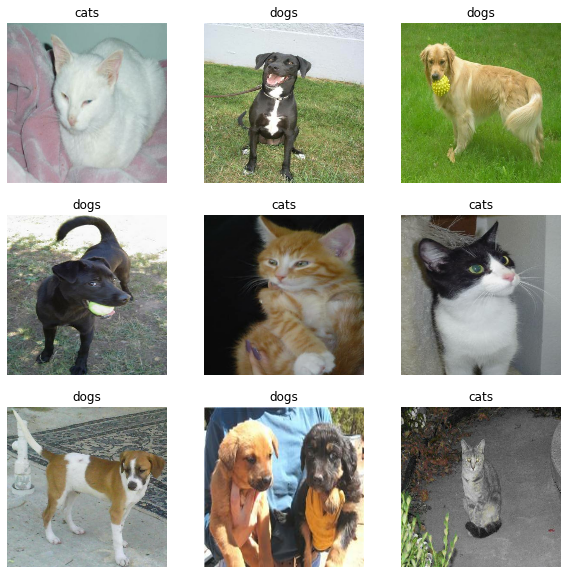

In [63]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

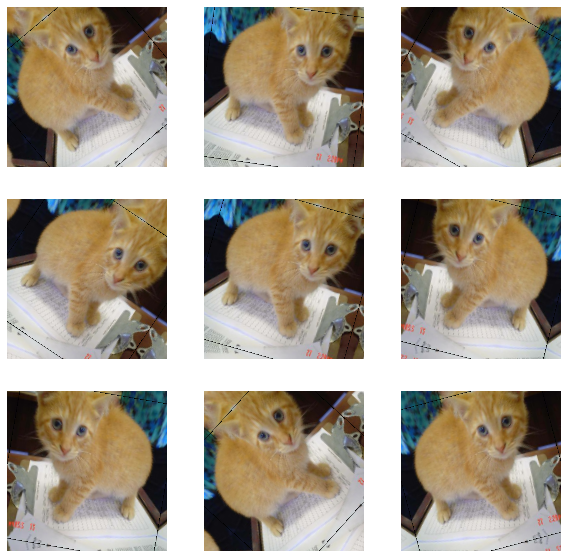

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

## Create Model

In [27]:
IMG_SHAPE = IMG_SIZE + (3,)
BASE_LEARNING_RATE = 0.0001
FINE_TUNING_RATE = 1e-5

### Feature Extractor

In [11]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 2560])

### Classification Head

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 2560])

In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 1])

### Compile

In [18]:
model_inputs = tf.keras.Input(shape=IMG_SHAPE)
_x = data_augmentation(model_inputs)
_x = tf.keras.applications.efficientnet.preprocess_input(_x)
_x = base_model(_x, training=False)
_x = global_average_layer(_x)
_x = tf.keras.layers.Dropout(0.2)(_x)
model_outputs = prediction_layer(_x)
model = tf.keras.Model(model_inputs, model_outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=BASE_LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 5, 5, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense (Dense)                multiple                  2561      
Total params: 64,100,248
Trainable params: 2,561
Non-trainable params: 64,097,687
______________________________________

In [19]:
len(model.trainable_variables)

2

## Training

### Top layer

In [38]:
INITIAL_EPOCHS = 10

In [21]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.65
initial accuracy: 0.54


In [22]:
history = model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_dataset,
)

Epoch 1/10
63/63 [==============================] - 154s 2s/step - loss: 0.5815 - accuracy: 0.5915 - val_loss: 0.4815 - val_accuracy: 0.6708
Epoch 2/10
63/63 [==============================] - 154s 2s/step - loss: 0.4525 - accuracy: 0.7580 - val_loss: 0.3712 - val_accuracy: 0.8589
Epoch 3/10
63/63 [==============================] - 157s 2s/step - loss: 0.3838 - accuracy: 0.8450 - val_loss: 0.3038 - val_accuracy: 0.9208
Epoch 4/10
63/63 [==============================] - 162s 3s/step - loss: 0.3237 - accuracy: 0.8895 - val_loss: 0.2586 - val_accuracy: 0.9455
Epoch 5/10
63/63 [==============================] - 161s 3s/step - loss: 0.2899 - accuracy: 0.9010 - val_loss: 0.2238 - val_accuracy: 0.9567
Epoch 6/10
63/63 [==============================] - 161s 3s/step - loss: 0.2652 - accuracy: 0.9135 - val_loss: 0.2014 - val_accuracy: 0.9579
Epoch 7/10
63/63 [==============================] - 164s 3s/step - loss: 0.2432 - accuracy: 0.9145 - val_loss: 0.1818 - val_accuracy: 0.9641
Epoch 8/10
63

### Fine Tuning

In [33]:
FINE_TUNE_EPOCHS = 10

In [31]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(FINE_TUNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 5, 5, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2560)              0         
_________________________________________________________________
dense (Dense)                multiple                  2561      
Total params: 64,100,248
Trainable params: 63,789,521
Non-trainable params: 310,727
____________________________________

In [32]:
len(model.trainable_variables)

711

In [39]:
history__fine_tune = model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
)

Epoch 10/20
63/63 [==============================] - 587s 9s/step - loss: 0.1272 - binary_accuracy: 0.9590 - val_loss: 0.0584 - val_binary_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 531s 8s/step - loss: 0.0665 - binary_accuracy: 0.9745 - val_loss: 0.0494 - val_binary_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 511s 8s/step - loss: 0.0509 - binary_accuracy: 0.9855 - val_loss: 0.0400 - val_binary_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 505s 8s/step - loss: 0.0483 - binary_accuracy: 0.9825 - val_loss: 0.0520 - val_binary_accuracy: 0.9802
Epoch 14/20
63/63 [==============================] - 545s 9s/step - loss: 0.0293 - binary_accuracy: 0.9925 - val_loss: 0.0411 - val_binary_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 539s 9s/step - loss: 0.0212 - binary_accuracy: 0.9945 - val_loss: 0.0454 - val_binary_accuracy: 0.9765
Epoch 16/20
63/63 [==============================] - 549s 9s/ste

## Prediction

In [52]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

In [105]:
model_output = model.predict(
    image_batch
).flatten()
predictions_sigmoid = tf.nn.sigmoid(model_output)
predictions_confidence = tf.abs(predictions_sigmoid - 0.5) / 0.5
predictions = tf.cast(tf.round(predictions_sigmoid), tf.int32).numpy()

In [106]:
print('Logits:\n', model_output)
print('Sigmoids:\n', predictions_sigmoid.numpy())
print('Confidence:\n', predictions_confidence.numpy())
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

Logits:
 [ -9.524282   -6.2914696   1.7110142  10.653584  -10.315224  -10.287303
   8.388721    5.499028   -9.103056   -9.218866    5.7864923   7.4927945
   6.120057   -6.460332    5.0730057 -10.950866  -10.649569    6.5488014
  -8.135914  -10.291397   -9.595373   -6.9783454 -10.783384    5.5036836
   8.597264   -9.749868    6.123255    7.348672   -8.867416  -10.611989
   5.2970686  -5.4862523]
Sigmoids:
 [7.30561296e-05 1.84854865e-03 8.46967816e-01 9.99976397e-01
 3.31249539e-05 3.40628576e-05 9.99772549e-01 9.95925963e-01
 1.11325084e-04 9.91510242e-05 9.96940672e-01 9.99443233e-01
 9.97806549e-01 1.56182051e-03 9.93775487e-01 1.75428213e-05
 2.37110689e-05 9.98570204e-01 2.92807817e-04 3.39236867e-05
 6.80428348e-05 9.30935144e-04 2.07412868e-05 9.95944798e-01
 9.99815464e-01 5.83023357e-05 9.97813463e-01 9.99356925e-01
 1.40875578e-04 2.46190757e-05 9.95018721e-01 4.12634015e-03]
Confidence:
 [0.9998539  0.9963029  0.69393563 0.9999528  0.9999338  0.9999319
 0.9995451  0.9918519  

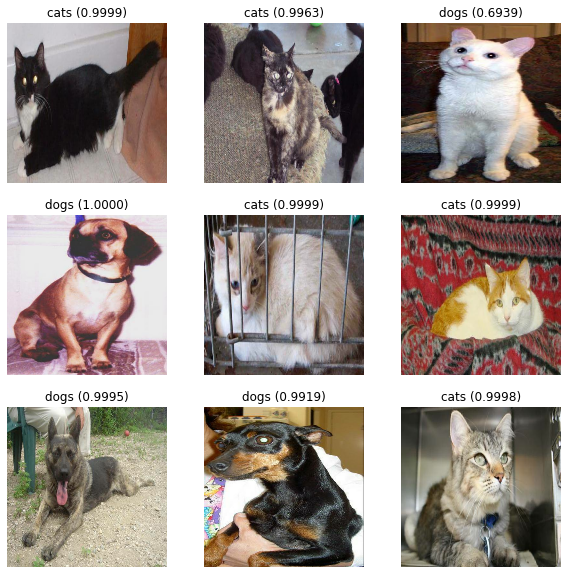

In [110]:
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"{class_names[predictions[i]]} ({predictions_confidence[i]:.4f})")
    plt.axis("off")

## References

* https://www.tensorflow.org/guide/keras/transfer_learning
* https://www.tensorflow.org/tutorials/images/transfer_learningBinaryCrossentropy